In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import os
import warnings
warnings.filterwarnings('ignore')
os.environ["PYTHONWARNINGS"] = "ignore"

## Import dependencies

In [4]:
import altair as alt
from altair import datum

import pandas as pd
import seaborn as sns
from IPython.display import display

from configs import config
from utils.data_viz_utils import create_average_metrics_df, visualize_fairness_metrics_for_prediction_metric
from utils.custom_classes.metrics_composer import MetricsComposer

sns.set_theme(style="whitegrid")

## Create average metrics files

In [5]:
DATASET_NAME = "COMPAS"
MODELS_NAMES = [model_config['model_name'] for model_config in config.MODELS_CONFIG if 'MLPClassifier' not in model_config['model_name']]

In [6]:
models_average_results_dct = create_average_metrics_df(DATASET_NAME, MODELS_NAMES,
                                                       results_path=os.path.join('..', '..', 'results', 'hypothesis_space', 'compas_metrics'))

File with average metrics for LogisticRegression is created
File with average metrics for DecisionTreeClassifier is created
File with average metrics for RandomForestClassifier is created
File with average metrics for XGBClassifier is created
File with average metrics for KNeighborsClassifier is created


## Visualize average metrics

In [7]:
PROTECTED_GROUPS = ['sex','race', 'sex_race']

# Example of MetricsComposer usage
metrics_composer = MetricsComposer(PROTECTED_GROUPS, models_average_results_dct['DecisionTreeClassifier'])
metrics_composer.compose_metrics()

,sex,race,sex_race
Equalized_Odds_TPR,-0.129383,0.287351,0.151429
Equalized_Odds_FPR,-0.155492,0.185483,0.022999
Disparate_Impact,0.738360,1.585498,1.225393
Statistical_Parity_Difference,-0.237624,0.365937,0.150827
Accuracy_Parity,0.051857,0.002734,0.039327
Label_Stability_Ratio,0.973227,0.907545,0.863985
IQR_Parity,0.022271,0.021760,0.051176
Std_Parity,0.020496,0.012441,0.036984
Std_Ratio,1.199522,1.125025,1.386469
Jitter_Parity,0.009025,0.049655,0.069641


### Overall metrics visualizations

In [8]:
def visualize_overall_metrics(models_average_results_dct, metrics_names, reversed_metrics_names=[], x_label="Prediction Metrics"):
    metrics_names = set(metrics_names + reversed_metrics_names)

    overall_metrics_df = pd.DataFrame()
    for model_name in models_average_results_dct.keys():
        model_average_results_df = models_average_results_dct[model_name].reset_index().copy(deep=True)
        model_average_results_df = model_average_results_df.loc[model_average_results_df['index'].isin(metrics_names)]
        overall_model_metrics_df = pd.DataFrame()
        overall_model_metrics_df['overall'] = model_average_results_df['overall']
        overall_model_metrics_df['metric'] = model_average_results_df['index']
        overall_model_metrics_df['model_name'] = model_name
        overall_metrics_df = pd.concat([overall_metrics_df, overall_model_metrics_df])

    overall_metrics_df.loc[overall_metrics_df['metric'].isin(reversed_metrics_names), 'overall'] = \
        1 - overall_metrics_df.loc[overall_metrics_df['metric'].isin(reversed_metrics_names), 'overall']

    # Draw a nested barplot
    height = 9 if len(metrics_names) >= 7 else 6
    g = sns.catplot(
        data=overall_metrics_df, kind="bar",
        x="overall", y="metric", hue="model_name",
        errorbar="sd", palette="bright",
        alpha=.8, height=height
    )
    g.despine(left=True)
    g.set_axis_labels("", x_label)
    g.legend.set_title("")


def overall_metric_comparison(prediction_metric_name, dataset_name, models_average_results_dct):
    comparison_df = pd.DataFrame(columns=('Dataset_Name', 'Metric_Name', 'Model_Name', 'Metric_Value'))
    for idx, model_name in enumerate(models_average_results_dct.keys()):
        model_average_results_df = models_average_results_dct[model_name]
        comparison_df.loc[idx] = [dataset_name, prediction_metric_name, model_name, model_average_results_df['overall'].loc[prediction_metric_name]]

    return comparison_df.sort_values(by=['Metric_Value'], ascending=False, axis=0)

In [9]:
def display_all_overall_metrics(dataset_name, model_names, models_average_results_dct):
    overall_metrics = list(models_average_results_dct[list(models_average_results_dct.keys())[0]].index)

    for overall_metric in overall_metrics:
        comparison_df = overall_metric_comparison(overall_metric, dataset_name, models_average_results_dct)
        print('#' * 30, f' {overall_metric} Comparison ', '#' * 30)
        display(comparison_df)

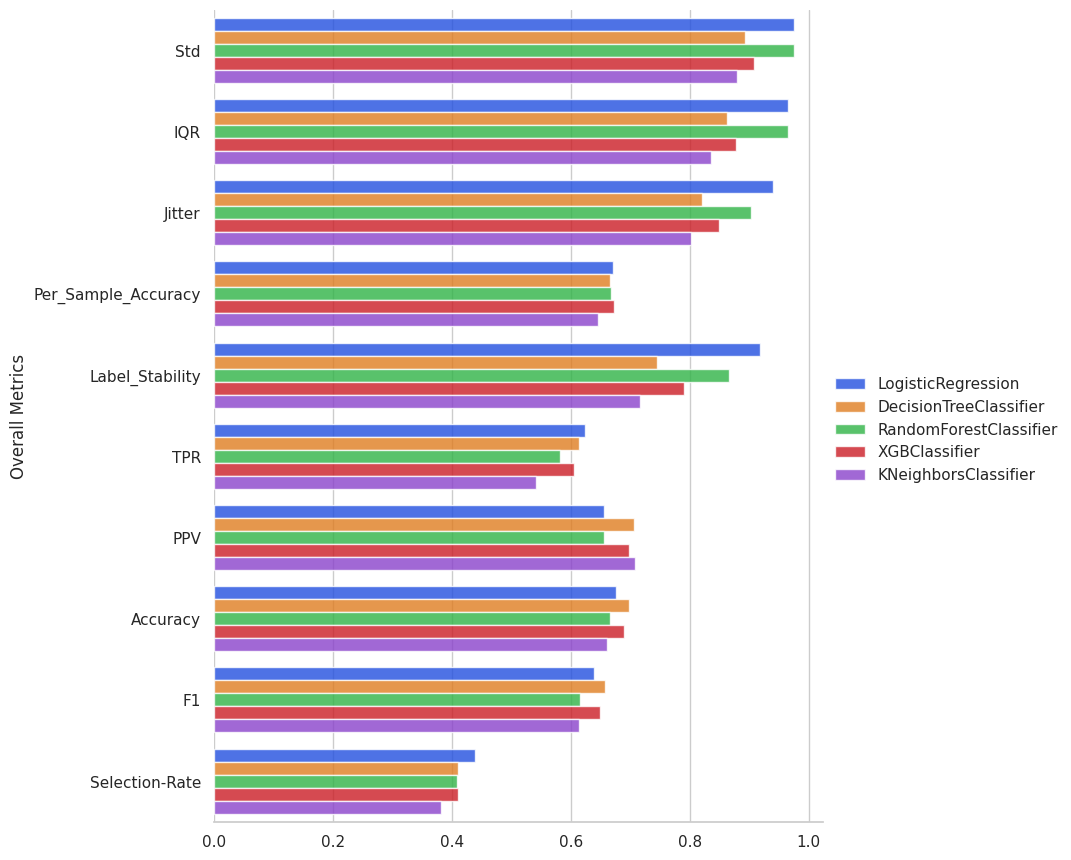

In [10]:
visualize_overall_metrics(models_average_results_dct,
                          metrics_names=['TPR', 'PPV', 'Accuracy', 'F1', 'Selection-Rate',
                                         'Per_Sample_Accuracy', 'Label_Stability'],
                          reversed_metrics_names=['Std', 'IQR', 'Jitter'],
                          x_label="Overall Metrics")

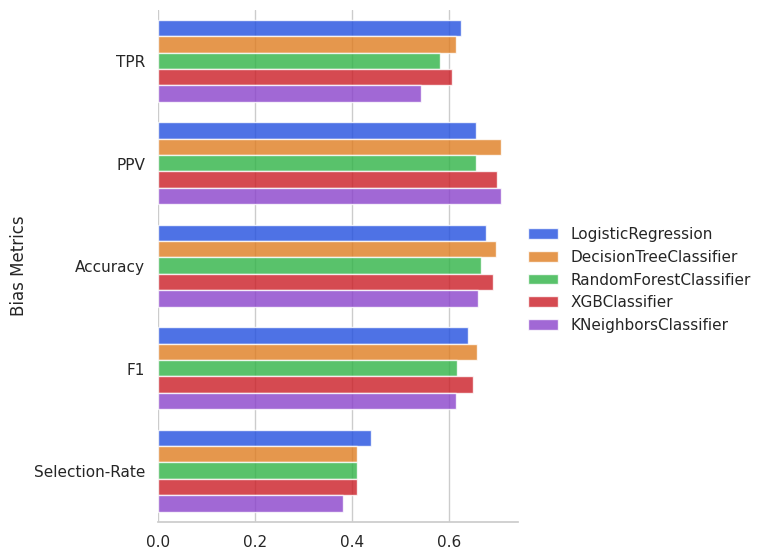

In [11]:
visualize_overall_metrics(models_average_results_dct,
                          metrics_names=['TPR', 'PPV', 'Accuracy', 'F1', 'Selection-Rate'],
                          x_label="Bias Metrics")

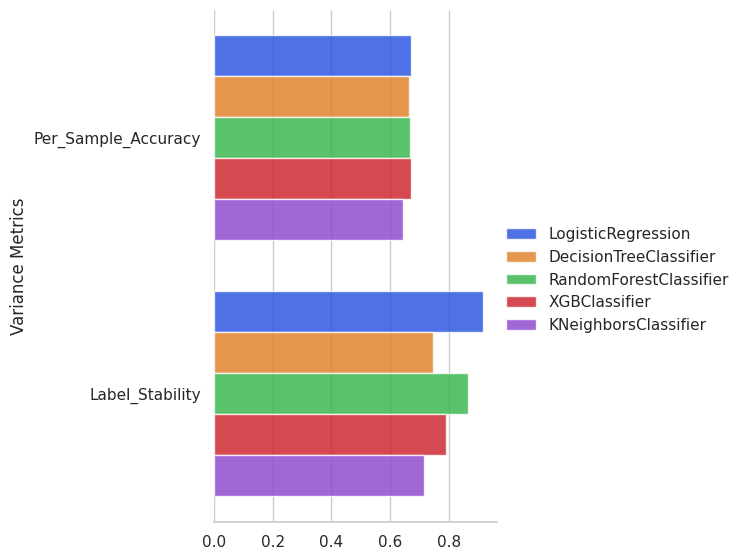

In [12]:
visualize_overall_metrics(models_average_results_dct,
                          metrics_names=['Per_Sample_Accuracy', 'Label_Stability'],
                          x_label="Variance Metrics")

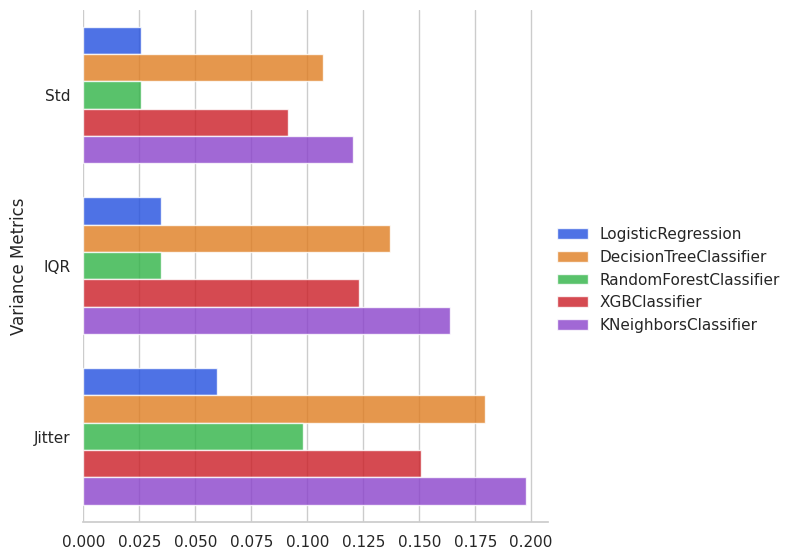

In [13]:
visualize_overall_metrics(models_average_results_dct,
                          metrics_names=['Std', 'IQR', 'Jitter'],
                          x_label="Variance Metrics")

In [14]:
models_average_results_df = pd.DataFrame()

for model_name in models_average_results_dct.keys():
    model_results_df = models_average_results_dct[model_name].reset_index()
    model_results_df['Model_Name'] = model_name
    model_results_df = model_results_df.rename(columns={"index": "Metric"})
    
    models_average_results_df = pd.concat([models_average_results_df, model_results_df])

models_average_results_df.head(30)

,Metric,overall,sex_race_priv,sex_race_dis,sex_priv,sex_dis,race_priv,race_dis,Model_Name
0,General_Ensemble_Accuracy,0.675189,0.672566,0.756757,0.660443,0.738693,0.681499,0.670906,LogisticRegression
1,Mean,0.524949,0.583063,0.581090,0.501687,0.625128,0.603180,0.471841,LogisticRegression
2,Std,0.025710,0.025196,0.028482,0.025383,0.027120,0.025239,0.026030,LogisticRegression
3,IQR,0.034829,0.034251,0.037536,0.034711,0.035336,0.033903,0.035458,LogisticRegression
4,Entropy,0.000000,0.000000,0.000000,0.000000,0.097209,0.000000,0.096173,LogisticRegression
5,Jitter,0.059860,0.061320,0.067610,0.059855,0.059881,0.059015,0.060434,LogisticRegression
6,Per_Sample_Accuracy,0.670582,0.668702,0.729189,0.659749,0.717236,0.675597,0.667178,LogisticRegression
7,Label_Stability,0.917150,0.912979,0.909009,0.916744,0.918894,0.916768,0.917409,LogisticRegression
8,TPR,0.624230,0.470149,0.511111,0.661871,0.400000,0.427673,0.719512,LogisticRegression
9,TNR,0.718805,0.804878,0.924242,0.659091,0.922481,0.832090,0.617940,LogisticRegression


In [15]:
df_for_models_bias_metrics_chart = models_average_results_df.melt(id_vars=["Metric", "Model_Name", "overall"],
                                                                  var_name="Subgroup",
                                                                  value_name="Value")
df_for_models_bias_metrics_chart[df_for_models_bias_metrics_chart["Model_Name"] == "LogisticRegression"]

,Metric,Model_Name,overall,Subgroup,Value
0,General_Ensemble_Accuracy,LogisticRegression,0.675189,sex_race_priv,0.672566
1,Mean,LogisticRegression,0.524949,sex_race_priv,0.583063
2,Std,LogisticRegression,0.025710,sex_race_priv,0.025196
3,IQR,LogisticRegression,0.034829,sex_race_priv,0.034251
4,Entropy,LogisticRegression,0.000000,sex_race_priv,0.000000
...,...,...,...,...,...
437,FPR,LogisticRegression,0.281195,race_dis,0.382060
438,Accuracy,LogisticRegression,0.675189,race_dis,0.670906
439,F1,LogisticRegression,0.639327,race_dis,0.695140
440,Selection-Rate,LogisticRegression,0.439394,race_dis,0.558029


In [16]:
models_composed_metrics_df = pd.DataFrame()
for model_name in models_average_results_dct.keys():
    metrics_composer = MetricsComposer(PROTECTED_GROUPS, models_average_results_dct[model_name])
    model_composed_metrics_df = metrics_composer.compose_metrics().reset_index()
    model_composed_metrics_df['Model_Name'] = model_name
    model_composed_metrics_df = model_composed_metrics_df.rename(columns={"index": "Metric"})
    
    models_composed_metrics_df = pd.concat([models_composed_metrics_df, model_composed_metrics_df])

models_composed_metrics_df.head(20)

,Metric,sex,race,sex_race,Model_Name
0,Equalized_Odds_TPR,-0.261871,0.291839,0.040962,LogisticRegression
1,Equalized_Odds_FPR,-0.263390,0.214149,-0.119364,LogisticRegression
2,Disparate_Impact,0.531388,1.505747,0.809493,LogisticRegression
3,Statistical_Parity_Difference,-0.478726,0.359430,-0.146434,LogisticRegression
4,Accuracy_Parity,0.078250,-0.010593,0.084190,LogisticRegression
5,Label_Stability_Ratio,1.002345,1.000699,0.995651,LogisticRegression
6,IQR_Parity,0.000625,0.001555,0.003286,LogisticRegression
7,Std_Parity,0.001737,0.000791,0.003286,LogisticRegression
8,Std_Ratio,1.068442,1.031360,1.130410,LogisticRegression
9,Jitter_Parity,0.000026,0.001419,0.006290,LogisticRegression


In [17]:
df_for_model_metrics_chart = models_composed_metrics_df.melt(id_vars=["Metric", "Model_Name"],
                                                                   var_name="Subgroup",
                                                                   value_name="Value")
df_for_model_metrics_chart[df_for_model_metrics_chart["Model_Name"] == "LogisticRegression"]

,Metric,Model_Name,Subgroup,Value
0,Equalized_Odds_TPR,LogisticRegression,sex,-0.261871
1,Equalized_Odds_FPR,LogisticRegression,sex,-0.263390
2,Disparate_Impact,LogisticRegression,sex,0.531388
3,Statistical_Parity_Difference,LogisticRegression,sex,-0.478726
4,Accuracy_Parity,LogisticRegression,sex,0.078250
5,Label_Stability_Ratio,LogisticRegression,sex,1.002345
6,IQR_Parity,LogisticRegression,sex,0.000625
7,Std_Parity,LogisticRegression,sex,0.001737
8,Std_Ratio,LogisticRegression,sex,1.068442
9,Jitter_Parity,LogisticRegression,sex,0.000026


In [18]:
def create_models_metrics_bar_chart(df, metrics_lst, default_plot_metric, metrics_group_name):
    df_for_model_metrics_chart = df.loc[df['Metric'].isin(metrics_lst)]
    
    radio_select = alt.selection_single(fields=['Metric'], init={'Metric': default_plot_metric}, empty="none")
    color_condition = alt.condition(radio_select,
                          alt.Color('Metric:N', legend=None, scale=alt.Scale(scheme="tableau20")),
                          alt.value('lightgray'))


    models_metrics_chart = (
        alt.Chart(df_for_model_metrics_chart)
            .mark_bar()
            .transform_filter(radio_select)
            .encode(
                x='Value:Q',
                y=alt.Y('Model_Name:N', axis=None),
                color=alt.Color(
                    'Model_Name:N',
                    scale=alt.Scale(scheme="tableau20")
                ),
                row='Subgroup:N',
            )
    )


    select_metric_legend = (
        alt.Chart(df_for_model_metrics_chart)
            .mark_circle(size=200)
            .encode(
                y=alt.Y("Metric:N", axis=alt.Axis(title=f"Select {metrics_group_name} Metric", titleFontSize=15)),
                color=color_condition,
            )
            .add_selection(radio_select)
    )


    color_legend = (
        alt.Chart(df_for_model_metrics_chart)
            .mark_circle(size=200)
            .encode(
                y=alt.Y("Model_Name:N", axis=alt.Axis(title="Model Name", titleFontSize=15)),
                color=alt.Color("Model_Name:N", scale=alt.Scale(scheme="tableau20")),
            )
    )
    
    return models_metrics_chart, select_metric_legend, color_legend

In [19]:
bias_metrics_lst = [
    'Accuracy_Parity',
    'Equalized_Odds_TPR',
    'Equalized_Odds_FPR',
    'Disparate_Impact',
    'Statistical_Parity_Difference',
]
models_bias_metrics_chart, select_bias_metric_legend, bias_color_legend = \
                create_models_metrics_bar_chart(df_for_model_metrics_chart, bias_metrics_lst, 
                                                default_plot_metric=bias_metrics_lst[0],
                                                metrics_group_name="Bias")

In [20]:
variance_metrics_lst = [
    'IQR_Parity',
    'Label_Stability_Ratio',
    'Std_Parity',
    'Std_Ratio',
    'Jitter_Parity',
]
models_variance_metrics_chart, select_variance_metric_legend, variance_color_legend = \
                create_models_metrics_bar_chart(df_for_model_metrics_chart, variance_metrics_lst,
                                                default_plot_metric=variance_metrics_lst[0],
                                                metrics_group_name="Variance")

In [21]:
(
    alt.hconcat(
        alt.vconcat(
            select_bias_metric_legend.properties(height=200, width=50),
            select_variance_metric_legend.properties(height=200, width=50),
            bias_color_legend.properties(height=200, width=50),
        ),
        models_bias_metrics_chart.properties(height=200, width=300),
        models_variance_metrics_chart.properties(height=200, width=300),
    )
)

alt.HConcatChart(...)